<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/main/notebooks/pose_rgb/pose_rgb_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "main"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 212 (delta 98), reused 137 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (212/212), 2.84 MiB | 18.66 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Cloned https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [2]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")


Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [5]:
!unzip /content/20251213_090435-20251213T104717Z-1-001.zip

Archive:  /content/20251213_090435-20251213T104717Z-1-001.zip
  inflating: 20251213_090435/training_history.png  
  inflating: 20251213_090435/training_history.json  
  inflating: 20251213_090435/best_model.pth  
  inflating: 20251213_090435/checkpoint_ep50.pth  


In [16]:
from src.pose_rgb.model import ResNetRotation, TranslationNet

model_path = "/content/20251213_090435/best_model.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

import torch

best_models = torch.load(model_path, map_location=torch.device(device))

best_models.keys()

model_rot = ResNetRotation()
model_rot.load_state_dict(best_models["model_rot"])
model_trans = TranslationNet()
model_trans.load_state_dict(best_models["model_trans"]);


🔒 ResNet backbone frozen.


In [18]:
from src.pose_rgb.dataset import LineModPoseDataset

test_dataset = LineModPoseDataset(dataset_root, "test")

 Loaded LineModPoseDataset
   Split: test
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


In [48]:
sample = test_dataset[4]
sample

img = sample['image'].unsqueeze(0).to(device)
bbox_info = sample["bbox_info"].unsqueeze(0).to(device)
gt_rot = sample["rotation"].to(device)
gt_trans = sample["translation"].to(device)
cam_K = sample["cam_K"].to(device)

# Set models to evaluation mode
model_rot.eval()
model_trans.eval()

pred_rot = model_rot(img)
pred_trans = model_trans(img, bbox_info)

In [49]:
print(pred_rot, gt_rot)
print(pred_trans, gt_trans)

tensor([[ 0.5040,  0.7427,  0.4040, -0.1765]], grad_fn=<DivBackward0>) tensor([ 0.3101,  0.6640,  0.6385, -0.2351])
tensor([[-0.1481, -2.6571,  0.9231]], grad_fn=<AddmmBackward0>) tensor([-0.1283,  0.0465,  1.0335])


In [50]:
sim = torch.dot(pred_rot.squeeze(0), gt_rot)
angle = 2 * torch.acos(sim)
print(sim, angle)

tensor(0.9489, grad_fn=<DotBackward0>) tensor(0.6422, grad_fn=<MulBackward0>)


In [40]:
!pip install plyfile
from utils.projection_utils import *

setup_projection_utils(dataset_root)




✅ LineModConfig initialized: /content/drive/.shortcut-targets-by-id/1sm0RTmd3Q00Uw99X5cErD8SxrnPrGS6v/Linemod_preprocessed


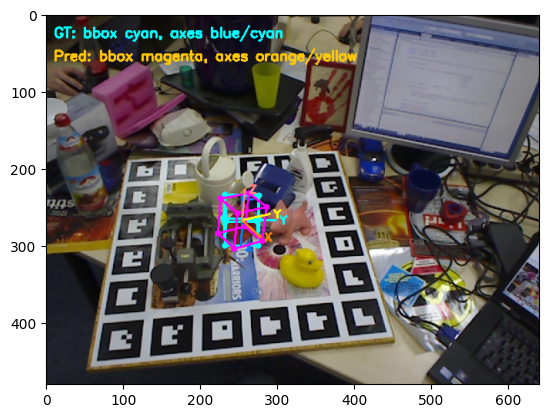

In [52]:
import matplotlib.pyplot as plt
import numpy as np

full_image = get_image_from_sample(sample)
object_id = sample['object_id']
cam_K = sample['cam_K']
gt_rotation = sample['rotation']# + 5e-2*np.random.randn()
gt_translation = sample['translation']# + 5e-2*np.random.randn()

plt.imshow(visualize_pose_comparison(
    full_image, object_id, cam_K, gt_rotation.detach().numpy(), gt_translation.detach().numpy(),
    pred_rot.squeeze(0).detach().numpy(), pred_trans.squeeze(0).detach().numpy()
))

